In [18]:
c_g = torch.load("../data/control_variates/control_variates_global_r22.pt")
c_l = torch.load("../data/control_variates/control_variates_c0_r22.pt")

In [29]:
import torch
import os.path
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import Subset, random_split, DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
import sys
import colorsys

In [2]:
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# Statistics

In [2]:
export_path = "/local/scratch/motterbe/save_runs/2023_07_31_1846"
global_epochs = 300

In [3]:
def load_if_exists(path):
    total_path = f"{export_path}/{path}"
    if os.path.exists(total_path):
        return torch.load(total_path, map_location="cpu")
    else:
        return None


variates = [[load_if_exists(f"control_variates_c{client}_r{round}.pt") for client in range(0,10)] for round in range(0,global_epochs)]
c_g = [load_if_exists(f"control_variates/control_variates_global_r{round}.pt")  for round in range(0,global_epochs)]

In [5]:
stats = load_pickle(f"{export_path}/stats.pkl")

loss_before = np.asarray([[client["loss_before"] for client in round_] for round_ in stats])
loss_after = np.asarray([[client["loss_after"] for client in round_] for round_ in stats])
acc_before = np.asarray([[client["correct"]/client["size"] for client in round_] for round_ in stats])
acc_after = np.asarray([[client["correct_after"]/client["size"] for client in round_] for round_ in stats])
index_array = np.arange(0, global_epochs, 1)

In [91]:
indexed_loss_before = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(loss_before.T)])
indexed_loss_after = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(loss_after.T)])
indexed_acc_before = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(acc_before.T)])
indexed_acc_after = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(acc_after.T)])

In [3]:
def plot_stat_by_epoch(stat, ax=None, line=None, counterstat = None, countername="Control Variate", stat_max_x = None, counter_max_y = None):
    if ax is None or line is None:
        line, ax = plt.subplots()
    
    ax.set(xlabel="Epoch", ylabel="Accuracy")
    if stat_max_x is not None:
        ax.set_ylim((0,stat_max_x))
    for client_id, client_stats in enumerate(stat):
        ax.plot(client_stats[0], client_stats[1], label=f"Client {client_id}")

    ax2 = ax.twinx()
    ax2.set(ylabel="Local Control Variate")

    ax2.invert_yaxis()
    if counter_max_y is not None:
        ax2.set_ylim((counter_max_y,0))
    if counterstat is not None:
        for client_id, client_stats in enumerate(counterstat):
            ax2.plot(client_stats[0], client_stats[1], label=f"{countername} {client_id}", color="r")
    # plt.legend(loc="upper left")

def plot_multiple_stats_by_epoch(stats, counterstats):
    plot_count = len(stats)
    left_count = math.ceil(plot_count/2)
    # right_count = math.floor(plot_count/2)

    (lines, axes) = plt.subplots(left_count, 2, figsize=(20,10))

    stat_max = stats[:, 1].max()
    counter_max= counterstats[:, 1].max()

    for plot_index in range(0, plot_count):
        col = plot_index%2
        row = math.floor(plot_index/2)
        

        plot_stat_by_epoch(stat=[stats[plot_index]], counterstat=[counterstats[plot_index]], ax=axes[row, col], line=lines, countername="Control Variate", counter_max_y=counter_max, stat_max_x=1)
        axes[row, col].set_title(f"Client {plot_index}")
    
    for ax in axes.flat:
        ax.label_outer()
    
    plt.show()
        

In [90]:
def trySum(a, b):
    if a is None or b is None:
        return None
    else:
        return ((a-b)**2).sum()

def tryMean(a,b):
    if a is None or b is None:
        return None
    else:
        comp = torch.stack([((global_layer-local_layer)**2).sum().sqrt() for (global_layer,local_layer) in zip(a, b)]).mean()
        return comp

inter_difs = [{f"{index1}_{index2}": tryMean(v1,v2) for (index2, v2) in enumerate(round_variates) for (index1, v1) in enumerate(round_variates) if index1 > index2}  for round_variates in variates]
diffs = [[tryMean(g, c_l) for c_l in c_ls] for (g, c_ls) in zip(c_g, variates)]
offset_diffs = [[tryMean(c_g[i], c_l) for c_l in variates[i+1]] for i in range(0,global_epochs-1)]

indexed_cv_global_diff = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index, client in enumerate(np.asarray(diffs).T)])

In [14]:
inter_dif_per_round = [torch.stack([clientDif for (diffName, clientDif) in round.items() if clientDif is not None]).mean().item() for round in inter_difs]


diffPerRound = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in diffs]
max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in diffs]
offset_diff_mean = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in offset_diffs]
offset_max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in offset_diffs]

In [95]:
indexed_acc_before[:,1].max()

0.9896428571428572

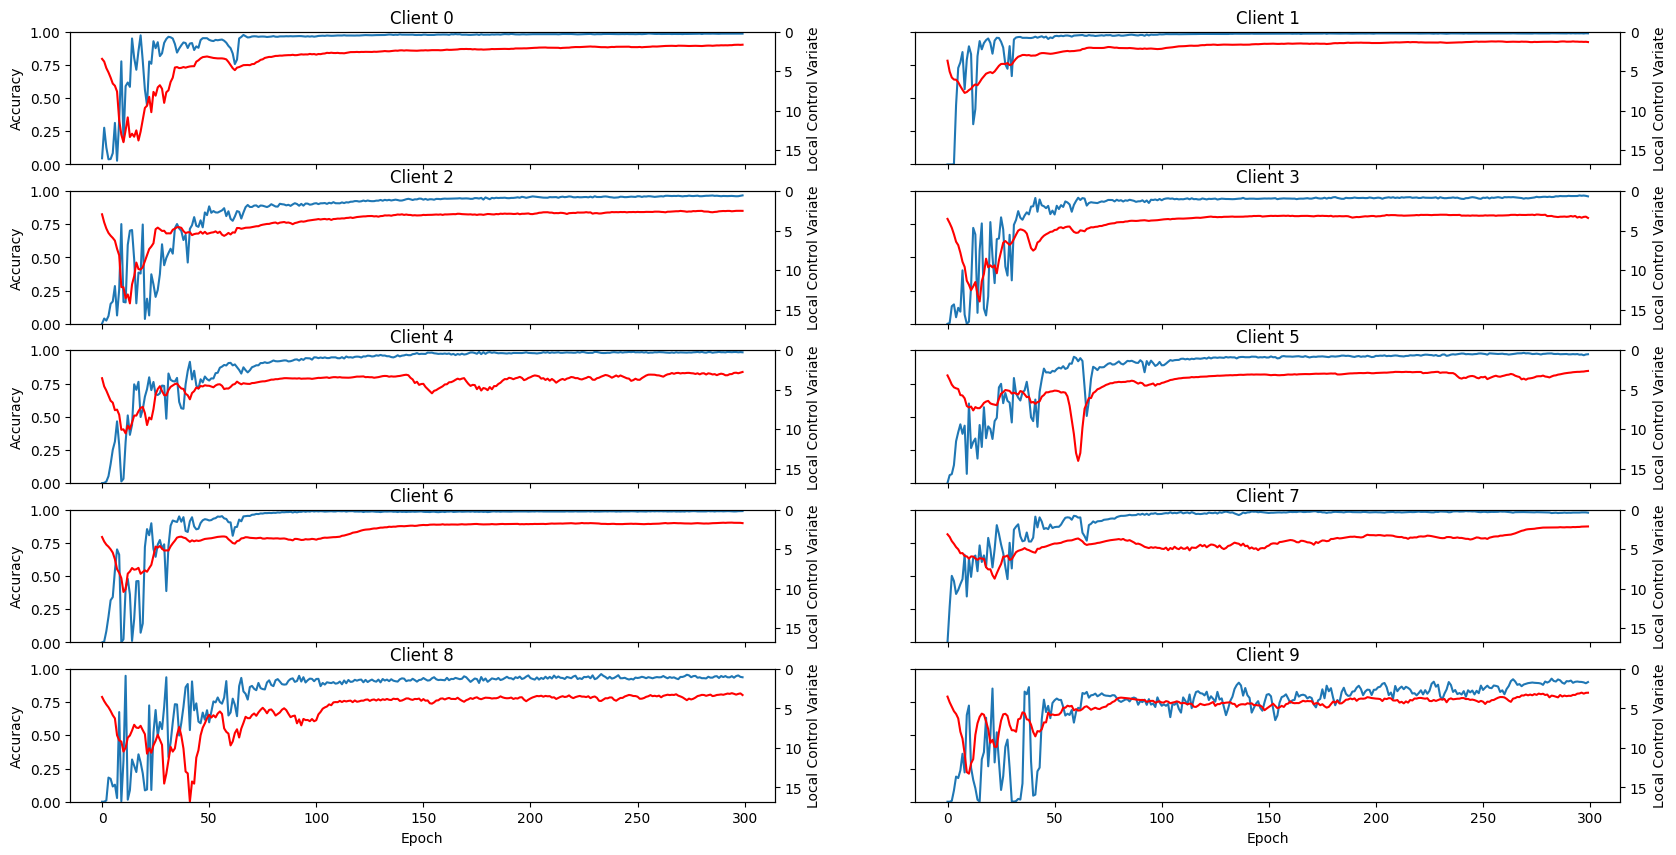

In [113]:
plot_multiple_stats_by_epoch(indexed_acc_before, indexed_cv_global_diff)

# Augmentations

In [9]:
# del sys.modules["utils.dataset.MNISTDataset"]
# del sys.modules["utils.dataset"]
# del sys.modules["utils"]
sys.path.append("../data")
# del colorcycle, CyclicDeform
# from utils.augmentations import colorcycle, CyclicDeform

In [4]:
from utils.dataset import CIFARDataset, MNISTDataset

pickle_path = "../data/emnist/pickles/0.pkl"
t = load_pickle(pickle_path)

In [227]:
torch.tensor([[1,1,1],[2,2,2]]).repeat_interleave(2, dim=0)

tensor([[1, 1, 1],
        [1, 1, 1],
        [2, 2, 2],
        [2, 2, 2]])

In [6]:
class AugSet(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [7]:
exports:torch.Tensor = torch.load(f"/local/scratch/motterbe/save_runs/2023_08_10_1424/pictest.pt", map_location="cpu")

tensor([0.2500, 0.5000, 0.4336])
tensor(783.0082) tensor(-0.5345)
tensor(783.5504) tensor(-0.5345)
tensor(776.3387) tensor(-0.5345)
tensor(778.0997) tensor(-0.5345)
tensor(782.9614) tensor(-0.5345)
tensor(778.5750) tensor(-0.5345)
tensor(784.3057) tensor(-0.5345)
tensor(776.9156) tensor(-0.5345)
tensor(777.5099) tensor(-0.5345)
tensor(780.0284) tensor(-0.5345)
tensor(781.2295) tensor(-0.5345)
tensor(783.6330) tensor(-0.5345)
tensor(782.1908) tensor(-0.5345)
tensor(777.3793) tensor(-0.5345)
tensor(780.0028) tensor(-0.5345)
tensor(780.9029) tensor(-0.5345)
tensor(769.7962) tensor(-0.5345)
tensor(778.8176) tensor(-0.5345)
tensor(784.4450) tensor(-0.5345)
tensor(775.0038) tensor(-0.5345)
tensor(784.4096) tensor(-0.5345)
tensor(781.9752) tensor(-0.5345)
tensor(782.4410) tensor(-0.5345)
tensor(758.5702) tensor(-0.5345)
tensor(781.5822) tensor(-0.5345)
tensor(780.7584) tensor(-0.5345)
tensor(766.9126) tensor(-0.5345)
tensor(780.4000) tensor(-0.5345)
tensor(781.2232) tensor(-0.5345)
tensor(784

IndexError: index 20 is out of bounds for axis 0 with size 20

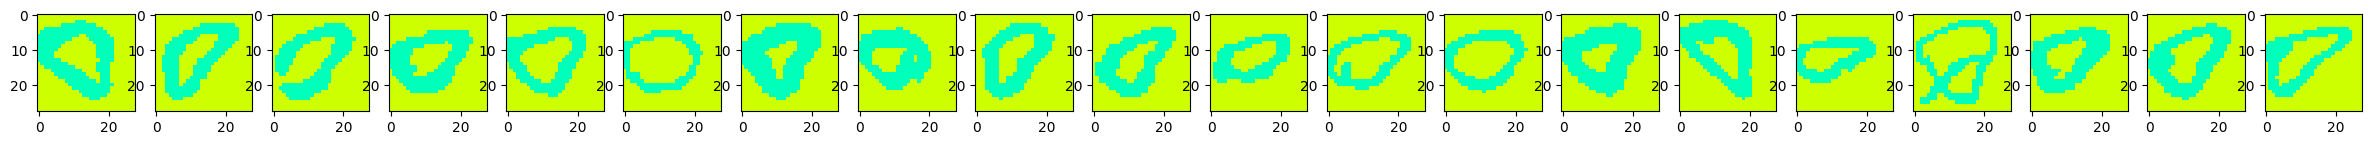

In [79]:
data_transforms = transforms.Compose([
    CyclicTorchDeform(epoch= 19, cycle= 100, img_size=(28,28), stretch_intensity=0.35),
    # transforms.Normalize(mean= 0, std=1),
    CycleColor(epoch = 25, cycle= 100, tolerance=0.3),
    # transforms.Normalize(mean= 0, std=1),
    # transforms.ToTensor()
])

aug_set = AugSet(t[0]["train"], data_transforms)
aug_loader =  DataLoader(aug_set, 32, shuffle=True)
i = iter(aug_loader)
x,y = aug_set[0]

fig, axs = plt.subplots(1,20, figsize=(30,10))

for batch_num, (xs, ys) in enumerate(aug_loader):
    x=xs[5]
    pic = x.permute(1, 2, 0).numpy()
    normalized = (pic - np.min(pic))/np.ptp(pic)

    axs[batch_num].imshow(normalized, cmap="gray")

# plt.imshow(x.transpose(1,2,0))


In [199]:
x.shape

torch.Size([3, 28, 28])

In [75]:
import numpy as np
import colorsys
import torch
import math
import elasticdeform

class CyclicTorchDeform:
    def __init__(self, epoch: int, cycle: int, img_size: tuple[int], stretch_intensity=3):
        self.epoch = epoch
        assert isinstance(epoch, int)
        assert isinstance(cycle, int)
        assert isinstance(img_size, tuple)
        
        angle = (epoch*360/cycle)%360
        x = math.sin(math.radians(angle))
        y = math.cos(math.radians(angle))
        
        displacement_grid = np.mgrid[-1:1:img_size[0]*1j, -1:1:img_size[1]*1j]
        
        displacement_weights = np.abs(x*-displacement_grid[0]-(-displacement_grid[1])*(y))/np.linalg.norm((x,y))
        displacement_weights -= 1
        displacement_weights = np.abs(displacement_weights)
        displacement_weights /= displacement_weights.max()
        displacement_weights = np.around(displacement_weights, 2)
        # z_displacement = np.full((control_points[0],control_points[1]), 1)
        # self.displacement = torch.from_numpy(np.asarray((z_displacement, y*displacement_weights, x*displacement_weights))* stretch_intensity)
        self.displacement = torch.from_numpy(np.asarray((x*displacement_weights, y*displacement_weights))* stretch_intensity)
        self.displacement = torch.unsqueeze(self.displacement.permute((1,2,0)), 0)
        # self.displacement = torch.unsqueeze(self.displacement, 1)
        # print(self.displacement.shape)

    def __call__(self, sample: torch.tensor):
        # image = sample.permute(1, 2, 0).numpy()[:,:,0]
        image = sample[0]
        # print(image.shape)
        # normalized = (image - torch.min(image))/np.ptp(image)
        # deformed = deform_grid(image, self.displacement)
        deformed = F.elastic_transform(sample, self.displacement)
        # deformed = elasticdeform.deform_grid(image.numpy(), self.displacement.numpy())
        return deformed


In [73]:
import numpy as np
import colorsys
import torch
import math
import elasticdeform

class CyclicDeform:
    def __init__(self, epoch: int, cycle: int, control_points: tuple[int], stretch_intensity=3):
        self.epoch = epoch
        assert isinstance(epoch, int)
        assert isinstance(cycle, int)
        assert isinstance(control_points, tuple)
        
        angle = (epoch*360/cycle)%360
        x = math.sin(math.radians(angle))
        y = math.cos(math.radians(angle))
        
        displacement_grid = np.mgrid[-1:1:control_points[0]*1j, -1:1:control_points[1]*1j]
        
        displacement_weights = np.abs(x*-displacement_grid[0]-(-displacement_grid[1])*(y))/np.linalg.norm((x,y))
        displacement_weights -= 1
        displacement_weights = np.abs(displacement_weights)
        displacement_weights /= displacement_weights.max()
        displacement_weights = np.around(displacement_weights, 2)
        z_displacement = np.full((control_points[0],control_points[1]), 1)
        # self.displacement = torch.from_numpy(np.asarray((z_displacement, y*displacement_weights, x*displacement_weights))* stretch_intensity)
        self.displacement = torch.from_numpy(np.asarray((x*displacement_weights, y*displacement_weights))* stretch_intensity)
        # self.displacement = torch.unsqueeze(self.displacement, 1)
        # print(self.displacement.shape)

    def __call__(self, sample: torch.tensor):
        # image = sample.permute(1, 2, 0).numpy()[:,:,0]
        image = sample[0]
        # print(image.shape)
        # normalized = (image - torch.min(image))/np.ptp(image)
        # deformed = deform_grid(image, self.displacement)
        deformed = elasticdeform.deform_grid(image.numpy(), self.displacement.numpy())
        return torch.unsqueeze(torch.from_numpy(deformed),0)


In [23]:
import numpy as np
import colorsys
import math

class CycleColor:
    def __init__(self, epoch: int, cycle: int, tolerance: int):
        self.epoch = epoch
        self.background_hue = ((self.epoch+10)*360/cycle)%360
        self.digit_hue = ((self.epoch+30)*360/cycle)%360
        self.tolerance = tolerance
        self.rgb_background = torch.tensor(colorsys.hsv_to_rgb(math.radians(self.background_hue), 0.5, 0.5))
        self.rgb_digit = torch.tensor(colorsys.hsv_to_rgb(math.radians(self.digit_hue), 0.5, 0.5))
        print(self.rgb_digit)
    def __call__(self, sample: torch.tensor):
        max = torch.max(sample)
        min = torch.min(sample)
        image = (sample-min)/(max-min)

        background_mask = (image < image.min()+self.tolerance) & (image > image.min()-self.tolerance)
        digit_mask = ~background_mask
        color_pic = torch.concat((image,)*3, axis=0)
        color_pic[:,background_mask.squeeze()]  = self.rgb_background.unsqueeze(1)
        color_pic[:,digit_mask.squeeze()]  = self.rgb_digit.unsqueeze(1)
        return color_pic


In [73]:
tensor_pic = t[0]["train"][0][0]
numpy_pic = tensor_pic.permute(1, 2, 0).numpy()

In [80]:
def color_and_normalize(pic, background_hue, digit_hue, intensity_tolerance):
    background_mask = (pic < pic.min()+intensity_tolerance) & (pic > pic.min()-intensity_tolerance)
    digit_mask = ~background_mask#(pic < pic.max()+range) & (pic > pic.max()-range)
    normalized = (pic - np.min(pic))/np.ptp(pic)
    color_pic = np.concatenate((normalized,)*3, axis=2)

    color_pic[background_mask.squeeze(), :]  = colorsys.hsv_to_rgb(math.radians(background_hue), 0.5, 0.5)
    color_pic[digit_mask.squeeze(), :]  = colorsys.hsv_to_rgb(math.radians(digit_hue), 0.5, 0.5)
    return color_pic

def cyclic_deform(sample, epoch, cycle, img_size, axs=None, axs_index=None):
    stretch_intensity = 1
    angle = (epoch*360/cycle)%360
    x = math.sin(math.radians(angle))
    y = math.cos(math.radians(angle))
    
    displacement_grid = np.mgrid[-1:1:img_size[0]*1j, -1:1:img_size[1]*1j]
    
    displacement_weights = np.abs(x*-displacement_grid[0]-(-displacement_grid[1])*(y))/np.linalg.norm((x,y))
    displacement_weights -= 1
    displacement_weights = np.abs(displacement_weights)
    displacement_weights /= displacement_weights.max()
    displacement_weights = np.around(displacement_weights, 2)
    # z_displacement = np.full((control_points[0],control_points[1]), 1)
    # self.displacement = torch.from_numpy(np.asarray((z_displacement, y*displacement_weights, x*displacement_weights))* stretch_intensity)
    displacement = torch.from_numpy(np.asarray((x*displacement_weights, y*displacement_weights))* stretch_intensity)
    displacement = torch.unsqueeze(displacement.permute((1,2,0)), 0)
    deformed = F.elastic_transform(sample, displacement, )

    if(axs is not None and axs_index is not None):
        if(axs[0, axs_index] is not None):
            ax = axs[0, axs_index]
            ax.axline((15,15), (15+x,15+y), color="white")

        if(axs[1, axs_index] is not None):
            ax = axs[1, axs_index]
            ax.imshow(displacement_weights, vmax=1, vmin=0)

        if(axs[2, axs_index] is not None):
            ax = axs[2, axs_index]
            ax.imshow(np.abs(displacement[0,:,:,0]), vmax=stretch_intensity, vmin=0)

        if(axs[3, axs_index] is not None):
            ax = axs[3, axs_index]
            ax.imshow(np.abs(displacement[0,:,:,1]), vmax=stretch_intensity, vmin=0)

    return deformed.permute((1,2,0)).numpy()


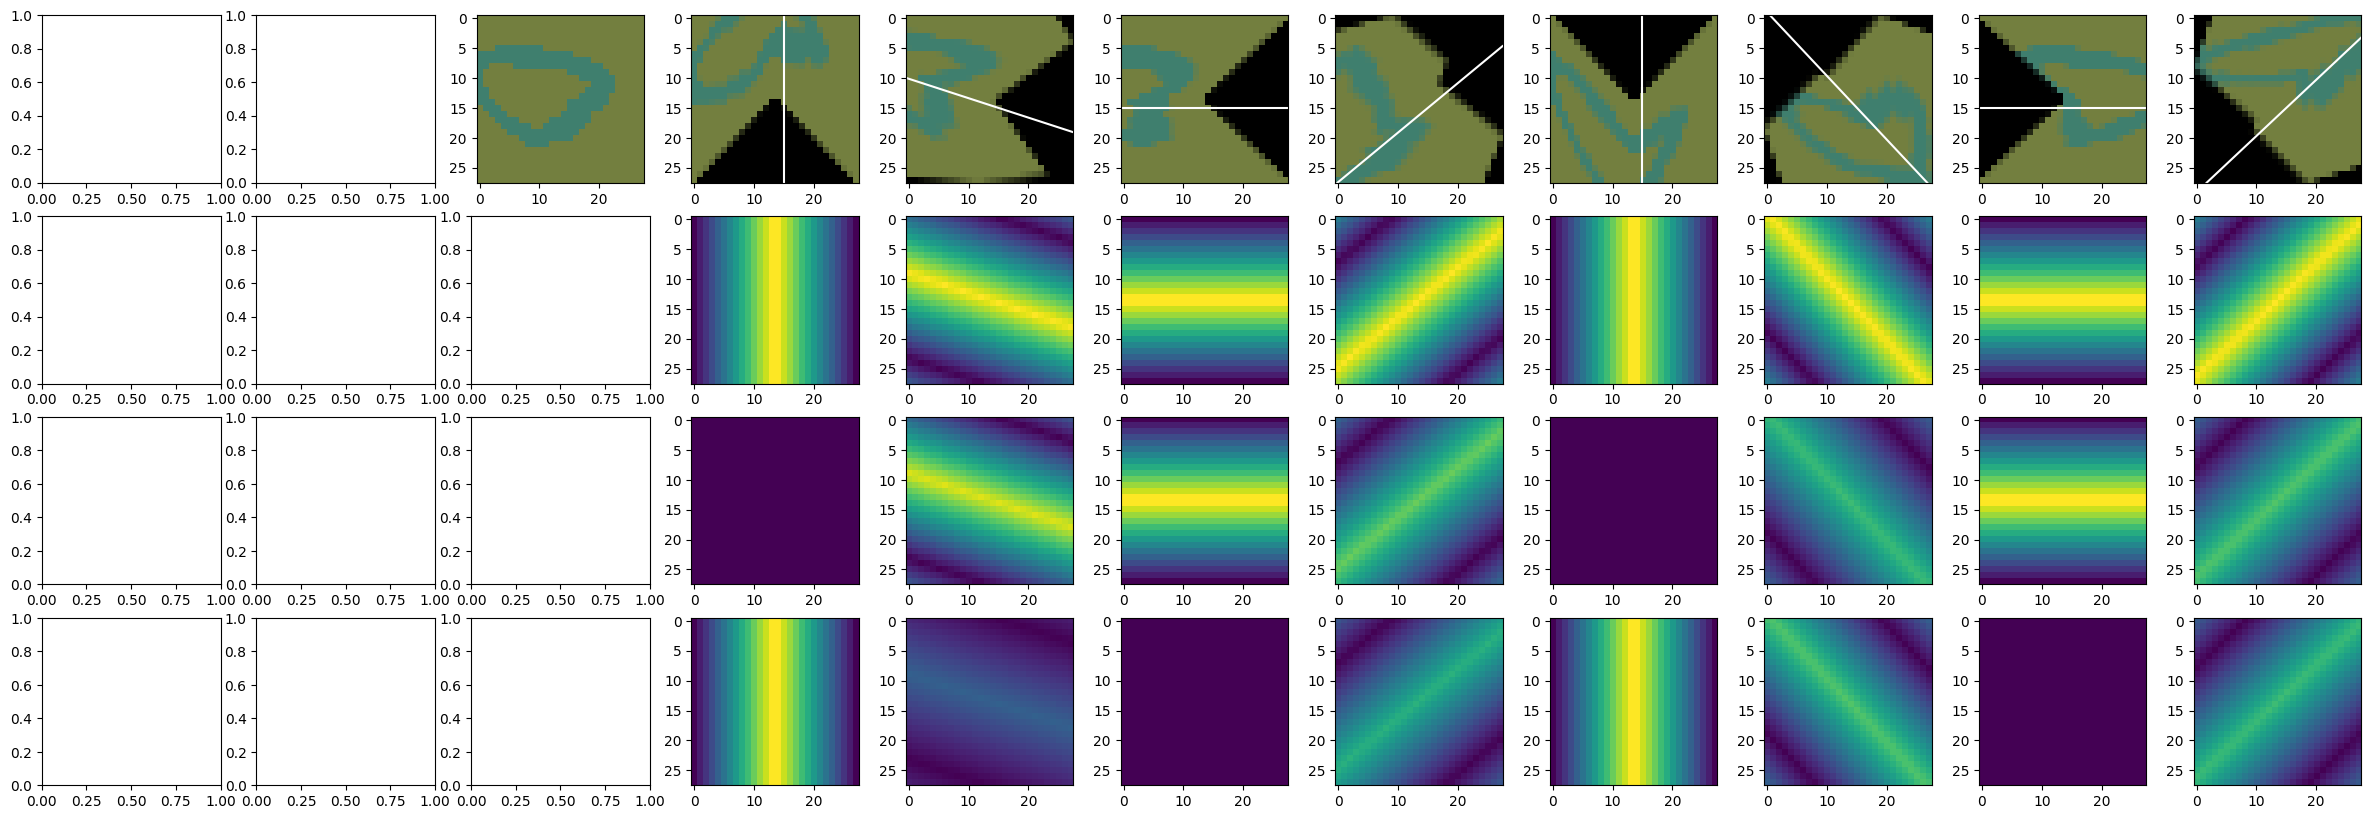

In [81]:
out_pic = x
# mask = out_pic == out_pic.min()
# out_pic[mask] = out_pic.max()

deform_grid = (28,28)

intensity_tolerance = 500
line, axs = plt.subplots(4,11, figsize=(30,10))
# axs[0, 0].imshow(color_and_normalize(out_pic, 50, 300, intensity_tolerance))
# axs[0, 1].imshow(color_and_normalize(out_pic, 0, 120, intensity_tolerance))
# axs[2].imshow(color_and_normalize(out_pic, 180, 270, intensity_tolerance))
axs[0, 2].imshow(out_pic.permute((1,2,0)).numpy(), cmap="gray")
axs[0, 3].imshow(cyclic_deform(out_pic, 0, 100, deform_grid, axs, 3), cmap="gray")
axs[0, 4].imshow(cyclic_deform(out_pic, 20, 100, deform_grid, axs, 4), cmap="gray")
axs[0, 5].imshow(cyclic_deform(out_pic, 25, 100, deform_grid, axs, 5), cmap="gray")
axs[0, 6].imshow(cyclic_deform(out_pic, 36, 100, deform_grid, axs, 6), cmap="gray")
axs[0, 7].imshow(cyclic_deform(out_pic, 50, 100, deform_grid, axs, 7), cmap="gray")
axs[0, 8].imshow(cyclic_deform(out_pic, 62, 100, deform_grid, axs, 8), cmap="gray")
axs[0, 9].imshow(cyclic_deform(out_pic, 75, 100, deform_grid, axs, 9), cmap="gray")
axs[0, 10].imshow(cyclic_deform(out_pic, 87, 100, deform_grid, axs, 10), cmap="gray")